In [1]:
%matplotlib inline
import sys, copy
sys.path.append('/home/igr/src/model/nengo_maze_env')
from functools import partial
import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from prf_net import PRF
from hsp import HSP
from rmsp import RMSP
from tqdm import tqdm
import scipy.interpolate
from scipy.interpolate import Rbf, PchipInterpolator, Akima1DInterpolator
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance, sample_by_activity)
from nengo_extras.neurons import (
    rates_kernel, rates_isi, spikes2events )

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module '_yaml' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def contiguous_ranges(input, return_indices=False):
    """Finds contiguous regions of the array "input". Returns
    a list of ranges with the start and end index of each region. Code based on:
    https://stackoverflow.com/questions/4494404/find-large-number-of-consecutive-values-fulfilling-condition-in-a-numpy-array/4495197
    """

    # Find the indices of changes in "condition"
    d = np.diff(input)
    nz, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the ranges by 1 to the right.
    nz += 1
    nz = np.concatenate([nz, [input.size]])
    
    ranges = np.vstack([ [nz[ri], nz[ri+1]] for ri in range(nz.size-1) ])
    ranges = np.vstack([[0, nz[0]], ranges])

    # Reshape the result into two columns
    ranges.shape = (-1,2)

    if return_indices:
        result = ( np.arange(*r) for r in ranges )
    else:
        result = ranges

    return result

In [3]:
#download mnist dataset
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_data.shape)

#flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))
print(np.max(test_data))

print(test_labels.shape)

(60000, 28, 28)
255
(10000,)


In [4]:
train_data = train_data.astype(np.float32)
train_data -= np.mean(train_data)
test_data = test_data.astype(np.float32)
test_data -= np.mean(test_data)



In [5]:
# reshaping the data again for use in simulation, since with spiking networks simulations are temporal
# shape: (batch_size, n_steps, n)
n_steps = 100
n_train = 500
train_data = np.tile(train_data[:n_train, None, :], (1, n_steps, 1))

# # when testing our network with spiking neurons we will need to run it 
# # over time, so we repeat the input/target data for a number of 
# # timesteps.

n_test = 100
test_data = np.tile(test_data[:n_test, None, :], (1, n_steps, 1))


In [6]:
test_labels = np.tile(test_labels[:, None], (1, n_steps))
print(train_data.shape)
print(test_data.shape)

(500, 100, 784)
(100, 100, 784)


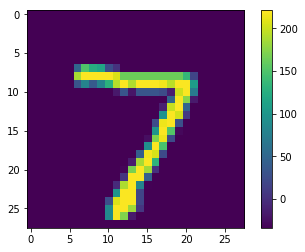

In [7]:
plt.figure()
plt.imshow(test_data[0, n_steps-1].reshape((28,28)), interpolation="nearest", aspect="equal")
plt.colorbar();

In [8]:
def image_input(input_matrix, dt, t, *args):
    ind = int(t / dt)
    activity = input_matrix[ind,:]
    on = np.maximum(0., activity)
    off = np.maximum(0., -activity)
    return np.concatenate([on, off])


In [9]:
def reward_input(mat, dt, t, *args):
    n = mat.shape[0]
    return mat[int(t/dt) % n]


In [10]:
dt = 0.001

seed = 27

xdim = 28
ydim = 28
original_dim = xdim*ydim
enc_dim = 64

n_outputs = enc_dim
n_excitatory_encoder = 2*original_dim
n_inhibitory_encoder = int(n_excitatory_encoder * 0.25)

n_excitatory_value = 192
n_inhibitory_value = int(n_excitatory_value * 0.25)

train_t_end = n_train * n_steps * dt - dt
print(f'train_t_end = {train_t_end}')            
test_t_end = n_test * n_steps * dt - dt
print(f'test_t_end = {test_t_end}')            

peak_rate_reward = 4.

train_input_matrix = train_data.reshape((-1, original_dim))
test_input_matrix = test_data.reshape((-1, original_dim))

print(f'train_data shape = {train_data.shape}')
print(f'train_input_matrix shape = {train_input_matrix.shape}')
print(f'max(train_input_matrix) = {np.max(train_input_matrix)}')

print(f'test_data shape = {test_data.shape}')
print(f'test_input_matrix shape = {test_input_matrix.shape}')
print(f'max(test_input_matrix) = {np.max(test_input_matrix)}')

train_reward_input_matrix_0 = np.zeros(train_labels.shape)
train_reward_input_matrix_0[np.argwhere(train_labels == 0)] = peak_rate_reward

train_reward_input_matrix_1 = np.zeros(train_labels.shape)
train_reward_input_matrix_1[np.argwhere(train_labels == 1)] = peak_rate_reward

print(f'max(train_reward_input_matrix_0) = {np.max(train_reward_input_matrix_0)}')



train_t_end = 49.999
test_t_end = 9.999
train_data shape = (500, 100, 784)
train_input_matrix shape = (50000, 784)
max(train_input_matrix) = 221.68154907226562
test_data shape = (100, 100, 784)
test_input_matrix shape = (10000, 784)
max(test_input_matrix) = 221.20875549316406
max(train_reward_input_matrix_0) = 4.0


In [11]:
dflt_enc_params = {'isp_target_rate': 2.0,
 
                    'w_input': 1e-2,
                    'w_initial_E': 0.0003,
                    'w_initial_E_Fb': 0.0001,
                    'w_initial_EI': 0.0008,
                    'w_initial_I': -0.0005,
                    'w_EI_Ext': 0.00086,
                    'w_II': 0.0005,
                      
                    'p_E': 0.25,
                    'p_EE': 0.05,
                    'p_EI': 0.4,
                    'p_EI_Ext': 0.15,
                    'p_E_Fb': 0.03,
                    'p_II': 0.06,
                      
                    'tau_E': 0.01,
                    'tau_I': 0.015,
                    'tau_input': 0.005,
                      
                    'learning_rate_I': 1e-4,
                    'learning_rate_E': 3e-4
                    }

dflt_val_params = {'isp_target_rate': 2.0,

                    'w_input': 1e-2,
                    'w_initial_E': 0.001,
                    'w_initial_E_Fb': 0.0001,
                    'w_initial_EI': 0.0008,
                    'w_initial_I': -0.005,
                    'w_EI_Ext': 0.0005,
                    'w_II': 0.0005,
                        
                    'p_E': 0.25,
                    'p_EE': 0.05,
                    'p_EI': 0.4,
                    'p_EI_Ext': 0.15,
                    'p_E_Fb': 0.03,
                    'p_II': 0.05,
                      
                    'tau_E': 0.01,
                    'tau_I': 0.015,
                    'tau_input': 0.005,
                      
                    'learning_rate_I': 1e-3,
                    'learning_rate_E': 1e-4
                  }

dflt_reward_params = {'p_PV_E': 0.05,
                      'p_PV_I': 0.3,
                      'learning_rate': 1e-4,
                      'reward_tau': 0.005
                     }


def make_autoenc_network(n_excitatory_encoder,
                         n_inhibitory_encoder,
                         n_excitatory_value,
                         n_inhibitory_value,
                         n_outputs,
                         input_matrix,
                         reward_input_matrix_0=None,
                         reward_input_matrix_1=None,
                         seed=0,
                         enc_params = dflt_enc_params, 
                         val_params = dflt_val_params,
                         reward_params = dflt_reward_params
                        ):

    weights_PV_I = reward_params.get('weights_PV_I', None)
    weights_PV_E = reward_params.get('weights_PV_E', None)
    
    with nengo.Network(seed=seed) as model:

        rng = np.random.RandomState(seed=seed)

        model.enc_network = \
            PRF(exc_input_func = partial(image_input, input_matrix, dt),
                connect_exc_inh_input = True,
                connect_inh_inh_input = True,
                connect_exc_fb = True,
                n_excitatory = n_excitatory_encoder,
                n_inhibitory = n_inhibitory_encoder,
                n_outputs = n_outputs,
                **enc_params)
    
        model.value_network = \
            PRF(n_excitatory = n_excitatory_value,
                n_inhibitory = n_inhibitory_value,
                n_outputs = n_outputs,
                connect_exc_inh_input = True,
                connect_inh_inh_input = True,
                connect_exc_fb = True,
                label="Value network",
                seed=seed,
                **val_params)

        reward_tau = reward_params['reward_tau']
        p_PV_E = reward_params['p_PV_E']
        p_PV_I = reward_params['p_PV_I']
        reward_learning_rate = reward_params['learning_rate']
        
        n_reward = 2
        if weights_PV_E is not None:
            weights_initial_PV_E = weights_PV_E
        else:
            weights_initial_PV_E = np.zeros((n_reward, n_excitatory_value, n_outputs))
            for i in range(n_reward):
                for j in range(n_excitatory_value):
                    weights_dist_PV_E = rng.normal(size=n_outputs)
                    weights_initial_PV_E[i, j, :] = (weights_dist_PV_E - weights_dist_PV_E.min()) / (weights_dist_PV_E.max() - weights_dist_PV_E.min()) * 5e-4
                    sources = np.asarray(rng.choice(n_outputs, round(p_PV_E * n_outputs), replace=False), dtype=np.int32)
                    weights_initial_PV_E[i, j, np.logical_not(np.in1d(range(n_outputs), sources))] = 0.
                    

        model.conn_PV_E_0 = \
            nengo.Connection(model.enc_network.output.neurons,
                             model.value_network.exc.neurons,
                             transform=weights_initial_PV_E[0],
                             synapse=nengo.Alpha(0.01),
                             learning_rule_type=RMSP(learning_rate=reward_learning_rate))

        model.conn_PV_E_1 = \
           nengo.Connection(model.enc_network.output.neurons,
                            model.value_network.exc.neurons,
                            transform=weights_initial_PV_E[1],
                            synapse=nengo.Alpha(0.01),
                            learning_rule_type=RMSP(learning_rate=reward_learning_rate))
        
        if weights_PV_I is not None:
            weights_initial_PV_I = weights_PV_I
        else:
            weights_dist_PV_I = rng.uniform(size=n_inhibitory_value*n_outputs).reshape((n_inhibitory_value, n_outputs))
            weights_initial_PV_I = (weights_dist_PV_I - weights_dist_PV_I.min()) / (weights_dist_PV_I.max() - weights_dist_PV_I.min()) * 8e-4
            for i in range(n_inhibitory_value):
                sources = np.asarray(rng.choice(n_outputs, round(p_PV_I * n_outputs), replace=False), dtype=np.int32)
                weights_initial_PV_I[i, np.logical_not(np.in1d(range(n_outputs), sources))] = 0.

        model.conn_PV_I = \
            nengo.Connection(model.enc_network.output.neurons,
                             model.value_network.inh.neurons,
                             transform=weights_initial_PV_I,
                             synapse=nengo.Alpha(0.01))
        
        model.reward_input_0 = nengo.Node(output=partial(reward_input, reward_input_matrix_0, dt)
                                          if reward_input_matrix_0 is not None else lambda t: 0.0,
                                          size_out=1)
        model.reward_input_1 = nengo.Node(output=partial(reward_input, reward_input_matrix_1, dt)
                                          if reward_input_matrix_1 is not None else lambda t: 0.0,
                                          size_out=1)

        model.reward_conn_0 = nengo.Connection(model.reward_input_0, model.conn_PV_E_0.learning_rule,
                                               synapse=None)

        model.reward_conn_1 = nengo.Connection(model.reward_input_1, model.conn_PV_E_1.learning_rule,
                                               synapse=None)
        
    return model


In [12]:
autoenc_model = \
    make_autoenc_network(n_excitatory_encoder,
                         n_inhibitory_encoder,
                         n_excitatory_value,
                         n_inhibitory_value,
                         n_outputs,
                         train_input_matrix,
                         train_reward_input_matrix_0,
                         train_reward_input_matrix_1,
                         seed=seed)

probes_dict = {}
with autoenc_model:
    
    probes_dict['enc_spikes'] = nengo.Probe(autoenc_model.enc_network.output.neurons, 'spikes', synapse=None)
    probes_dict['val_spikes'] = nengo.Probe(autoenc_model.value_network.output.neurons, 'spikes', synapse=None)
    probes_dict['enc_exc_rates'] = nengo.Probe(autoenc_model.enc_network.exc.neurons, 'rates')
    probes_dict['enc_inh_rates'] = nengo.Probe(autoenc_model.enc_network.inh.neurons, 'rates')
    probes_dict['reward_input_0'] = nengo.Probe(autoenc_model.reward_input_0, synapse=None)
    probes_dict['reward_input_1'] = nengo.Probe(autoenc_model.reward_input_1, synapse=None)
    probes_dict['enc_weights_I'] = nengo.Probe(autoenc_model.enc_network.conn_I, 'weights', sample_every=5)
    probes_dict['enc_weights_E'] = nengo.Probe(autoenc_model.enc_network.conn_E, 'weights', sample_every=5)
    probes_dict['enc_weights_EE'] = None
    if autoenc_model.enc_network.conn_EE is not None:
        probes_dict['enc_weights_EE'] = nengo.Probe(autoenc_model.enc_network.conn_EE, 'weights', sample_every=5)
    probes_dict['enc_weights_E_Fb'] = None
    if autoenc_model.enc_network.conn_E_Fb is not None:
        probes_dict['enc_weights_E_Fb'] = nengo.Probe(autoenc_model.enc_network.conn_E_Fb, 'weights', sample_every=5)
    probes_dict['val_weights_I'] = nengo.Probe(autoenc_model.value_network.conn_I, 'weights', sample_every=5)
    probes_dict['val_weights_E'] = nengo.Probe(autoenc_model.value_network.conn_E, 'weights', sample_every=5)
    probes_dict['val_weights_EE'] = None
    if autoenc_model.value_network.conn_EE is not None:
        probes_dict['val_weights_EE'] = nengo.Probe(autoenc_model.value_network.conn_EE, 'weights', sample_every=5)
    probes_dict['val_weights_E_Fb'] = None
    if autoenc_model.value_network.conn_E_Fb is not None:
        probes_dict['val_weights_E_Fb'] = nengo.Probe(autoenc_model.value_network.conn_E_Fb, 'weights', sample_every=5)
    probes_dict['weights_PV_E_0'] = nengo.Probe(autoenc_model.conn_PV_E_0, 'weights', sample_every=5)
    probes_dict['weights_PV_E_1'] = nengo.Probe(autoenc_model.conn_PV_E_1, 'weights', sample_every=5)
    probes_dict['weights_PV_I'] = nengo.Probe(autoenc_model.conn_PV_I, 'weights', sample_every=5)
    
autoenc_model_probes = probes_dict

with nengo.Simulator(autoenc_model, optimize=True) as sim:
    sim.run(train_t_end)
 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

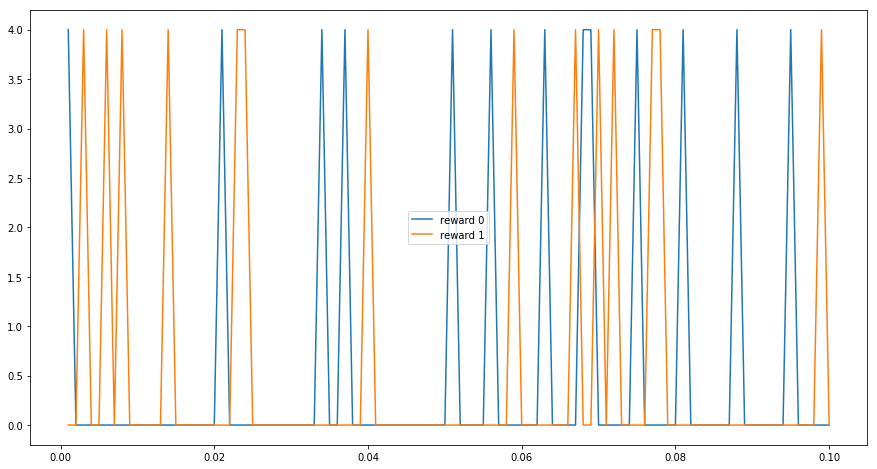

In [13]:
train_output = sim.data

train_reward_input_0 = train_output[autoenc_model_probes['reward_input_0']]
train_reward_input_1 = train_output[autoenc_model_probes['reward_input_1']]
plt.figure(figsize=(15,8))
plt.plot(sim.trange()[:100], train_reward_input_0[:100], label="reward 0")
plt.plot(sim.trange()[:100], train_reward_input_1[:100], label="reward 1")
plt.legend();


Mean encoder output rate is 2.3308966101773563
Max encoder output rate is 210.81544735200154


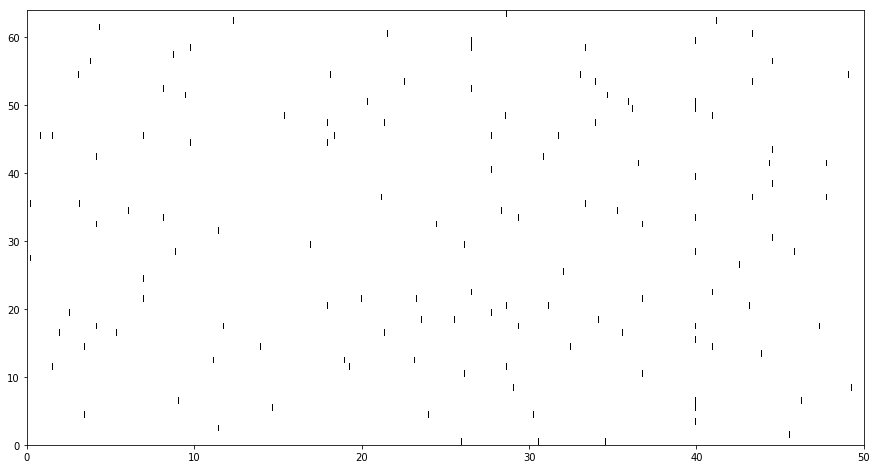

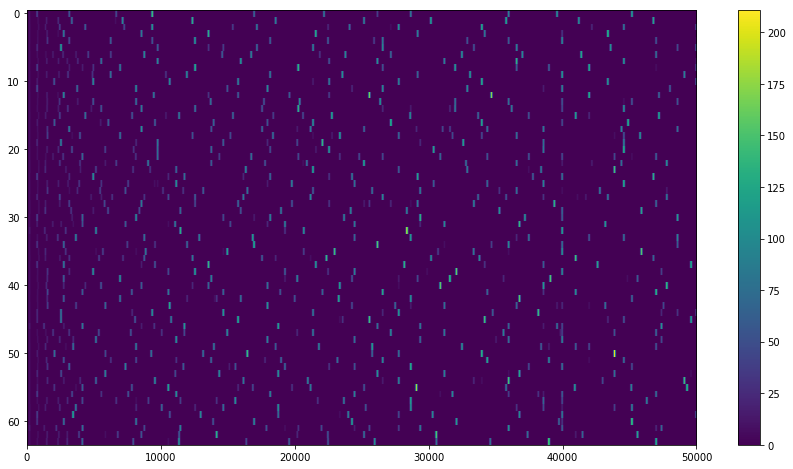

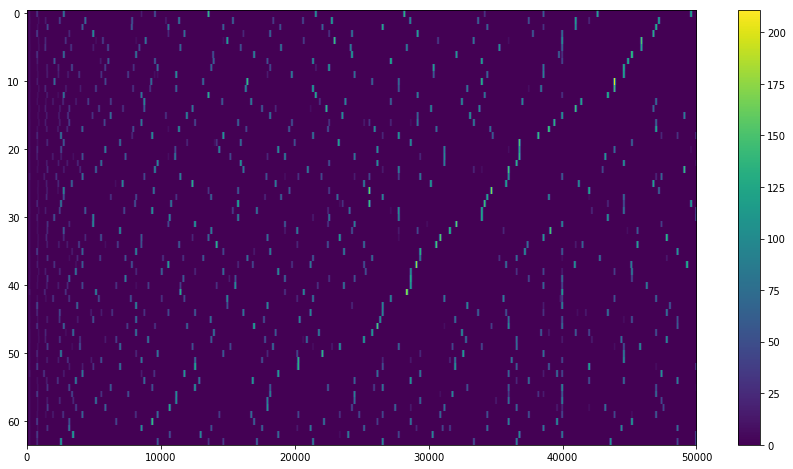

In [14]:
# plt.figure()
train_output = sim.data

enc_spikes = train_output[autoenc_model_probes['enc_spikes']]
enc_rates = rates_kernel(sim.trange(), enc_spikes, tau=0.1)
print(f'Mean encoder output rate is {np.mean(enc_rates)}')
print(f'Max encoder output rate is {np.max(enc_rates)}')

plt.figure(figsize=(15,8));

plot_spikes(sim.trange(), enc_spikes, origin='upper');


plt.figure(figsize=(15,8))
plt.imshow(enc_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();

plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(enc_rates.T, axis=1))
plt.imshow(enc_rates[:,sorted_idxs].T, interpolation="nearest", aspect="auto")
plt.colorbar();



(49999, 64)
Mean value output rate is 1.3472184780039484


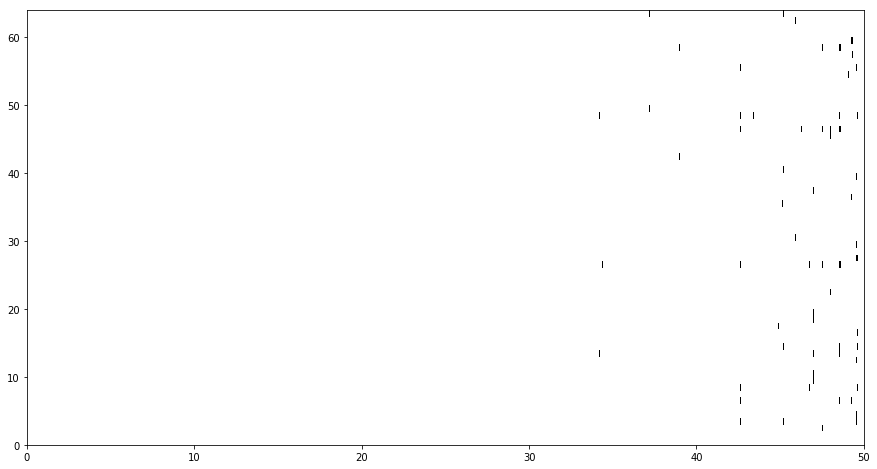

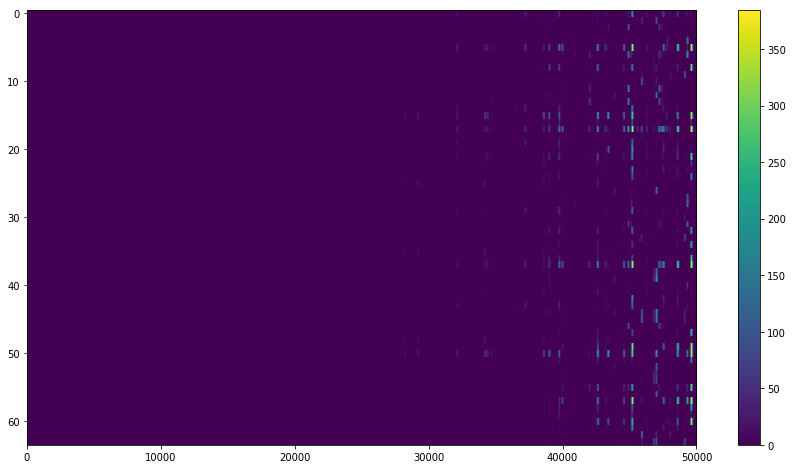

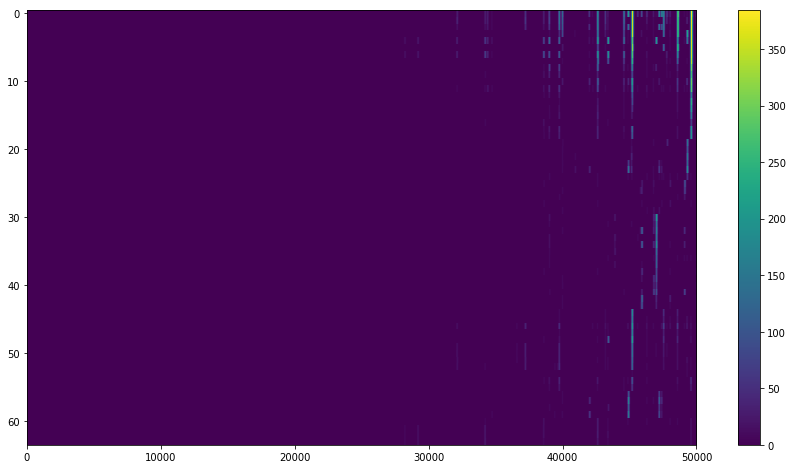

In [15]:
train_output = sim.data
print(train_output[autoenc_model_probes['val_spikes']].shape)

val_spikes = train_output[autoenc_model_probes['val_spikes']]
val_rates = rates_kernel(sim.trange(), val_spikes, tau=0.1)
print(f'Mean value output rate is {np.mean(val_rates)}')

plt.figure(figsize=(15,8));
plot_spikes(sim.trange(), val_spikes);


plt.figure(figsize=(15,8))
plt.imshow(val_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();

plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(val_rates.T, axis=1))
plt.imshow(val_rates[:,sorted_idxs].T, interpolation="nearest", aspect="auto")
plt.colorbar();



(9, 192, 64)


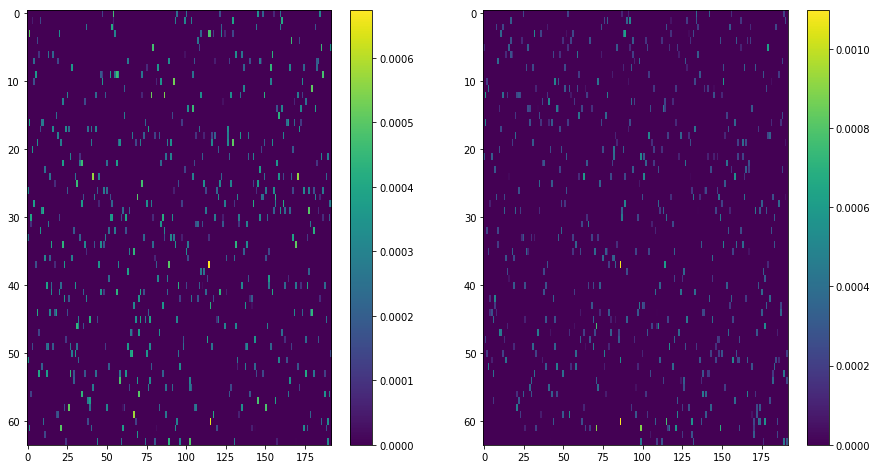

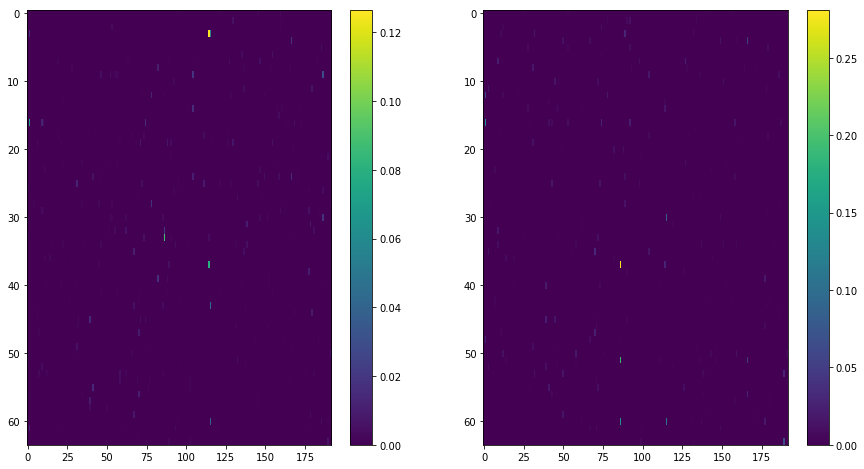

In [16]:
weights_PV_E_0 = train_output[autoenc_model_probes['weights_PV_E_0']]
weights_PV_E_1 = train_output[autoenc_model_probes['weights_PV_E_1']]
print(weights_PV_E_0.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
im1 = ax1.imshow(weights_PV_E_0[0,:,:].T, aspect='auto')
plt.colorbar(im1, ax=ax1);

im2 = ax2.imshow(weights_PV_E_1[0,:,:].T, aspect='auto');
plt.colorbar(im2, ax=ax2);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
im1 = ax1.imshow(weights_PV_E_0[-1,:,:].T, aspect='auto')
plt.colorbar(im1, ax=ax1);

im2 = ax2.imshow(weights_PV_E_1[-1,:,:].T, aspect='auto');
plt.colorbar(im2, ax=ax2);


In [18]:
train_output = sim.data

trained_enc_params = copy.deepcopy(dflt_enc_params)
trained_val_params = copy.deepcopy(dflt_val_params)
trained_reward_params = copy.deepcopy(dflt_reward_params)

trained_enc_params['weights_E']  = train_output[autoenc_model_probes['enc_weights_E']][-1,:,:]
trained_enc_params['weights_I']  = train_output[autoenc_model_probes['enc_weights_I']][-1,:,:]
trained_enc_params['weights_EE']  = train_output[autoenc_model_probes['enc_weights_EE']][-1,:,:]
trained_enc_params['weights_E_Fb']  = train_output[autoenc_model_probes['enc_weights_E_Fb']][-1,:,:]

trained_val_params['weights_E']  = train_output[autoenc_model_probes['val_weights_E']][-1,:,:]
trained_val_params['weights_I']  = train_output[autoenc_model_probes['val_weights_I']][-1,:,:]
trained_val_params['weights_EE']  = train_output[autoenc_model_probes['val_weights_EE']][-1,:,:]
trained_val_params['weights_E_Fb']  = train_output[autoenc_model_probes['val_weights_E_Fb']][-1,:,:]

trained_reward_params['weights_PV_E'] = \
    np.concatenate([train_output[autoenc_model_probes['weights_PV_E_0']][-1,:,:][np.newaxis, :],
                    train_output[autoenc_model_probes['weights_PV_E_1']][-1,:,:][np.newaxis, :],], 
                   axis=0)
#trained_reward_params['weights_PV_I'] = train_output[probes_dict['weights_PV_I][-1,:,:]

trained_autoenc_model = make_autoenc_network(n_excitatory_encoder,
                                             n_inhibitory_encoder,
                                             n_excitatory_value,
                                             n_inhibitory_value,
                                             n_outputs,
                                             test_input_matrix,
                                             enc_params=trained_enc_params,
                                             val_params=trained_val_params,
                                             reward_params = trained_reward_params,
                                             seed=seed)

probes_dict = {}
with trained_autoenc_model:
    probes_dict['enc_spikes'] = nengo.Probe(trained_autoenc_model.enc_network.output.neurons, 'spikes', synapse=None)
    probes_dict['val_spikes'] = nengo.Probe(trained_autoenc_model.value_network.output.neurons, 'spikes', synapse=None)
    probes_dict['enc_exc_rates'] = nengo.Probe(trained_autoenc_model.enc_network.exc.neurons, 'rates')
    probes_dict['enc_inh_rates'] = nengo.Probe(trained_autoenc_model.enc_network.inh.neurons, 'rates')
    probes_dict['reward_input_0'] = nengo.Probe(trained_autoenc_model.reward_input_0, synapse=None)
    probes_dict['reward_input_1'] = nengo.Probe(trained_autoenc_model.reward_input_1, synapse=None)
    probes_dict['enc_weights_I'] = nengo.Probe(trained_autoenc_model.enc_network.conn_I, 'weights', sample_every=5)
    probes_dict['enc_weights_E'] = nengo.Probe(trained_autoenc_model.enc_network.conn_E, 'weights', sample_every=5)
    probes_dict['enc_weights_EE'] = None
    if autoenc_model.enc_network.conn_EE is not None:
        probes_dict['enc_weights_EE'] = nengo.Probe(trained_autoenc_model.enc_network.conn_EE, 'weights', sample_every=5)
    probes_dict['enc_weights_E_Fb'] = None
    if autoenc_model.enc_network.conn_E_Fb is not None:
        probes_dict['enc_weights_E_Fb'] = nengo.Probe(trained_autoenc_model.enc_network.conn_E_Fb, 'weights', sample_every=5)
    probes_dict['val_weights_I'] = nengo.Probe(trained_autoenc_model.value_network.conn_I, 'weights', sample_every=5)
    probes_dict['val_weights_E'] = nengo.Probe(trained_autoenc_model.value_network.conn_E, 'weights', sample_every=5)
    probes_dict['val_weights_EE'] = None
    if trained_autoenc_model.value_network.conn_EE is not None:
        probes_dict['val_weights_EE'] = nengo.Probe(trained_autoenc_model.value_network.conn_EE, 'weights', sample_every=5)
    probes_dict['val_weights_E_Fb'] = None
    if trained_autoenc_model.value_network.conn_E_Fb is not None:
        probes_dict['val_weights_E_Fb'] = nengo.Probe(trained_autoenc_model.value_network.conn_E_Fb, 'weights', sample_every=5)
    probes_dict['weights_PV_E_0'] = nengo.Probe(trained_autoenc_model.conn_PV_E_0, 'weights', sample_every=5)
    probes_dict['weights_PV_E_1'] = nengo.Probe(trained_autoenc_model.conn_PV_E_1, 'weights', sample_every=5)
    probes_dict['weights_PV_I'] = nengo.Probe(trained_autoenc_model.conn_PV_I, 'weights', sample_every=5)

trained_autoenc_model_probes = probes_dict
with nengo.Simulator(trained_autoenc_model, optimize=True) as sim:
    sim.run(np.max(test_t_end))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

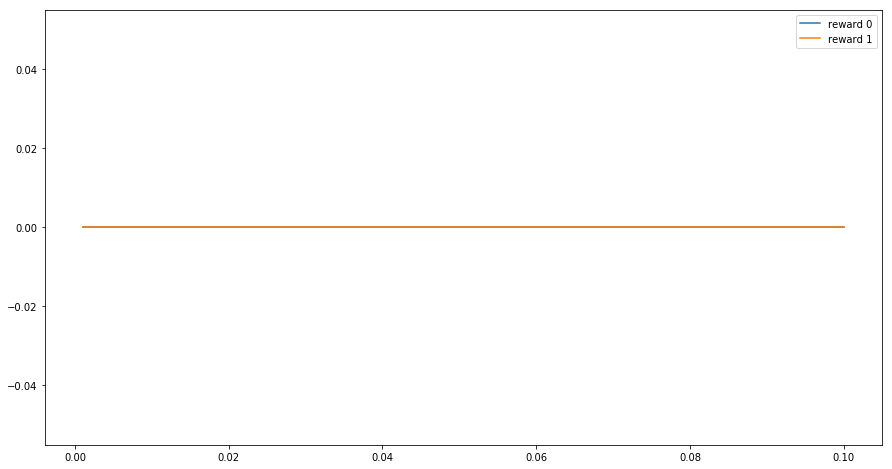

In [20]:
test_output = sim.data

test_reward_input_0 = test_output[trained_autoenc_model_probes['reward_input_0']]
test_reward_input_1 = test_output[trained_autoenc_model_probes['reward_input_1']]
plt.figure(figsize=(15,8))
plt.plot(sim.trange()[:100], test_reward_input_0[:100], label="reward 0")
plt.plot(sim.trange()[:100], test_reward_input_1[:100], label="reward 1")
plt.legend();


Mean encoder output rate is 1.850106479943905


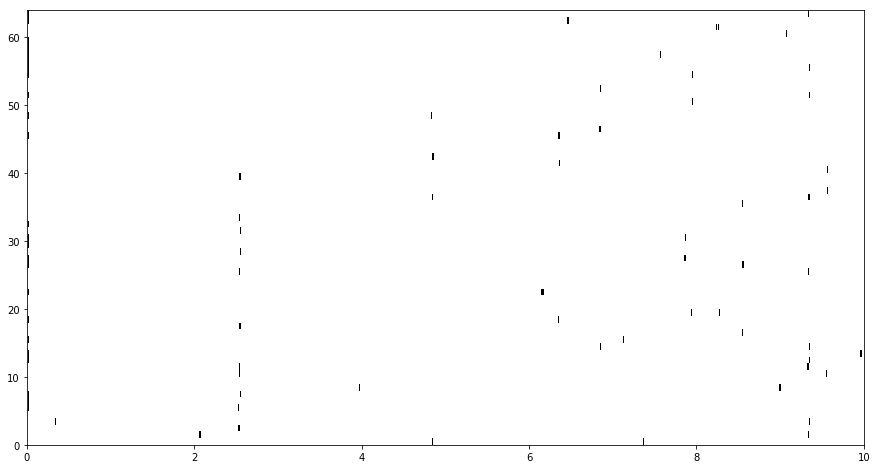

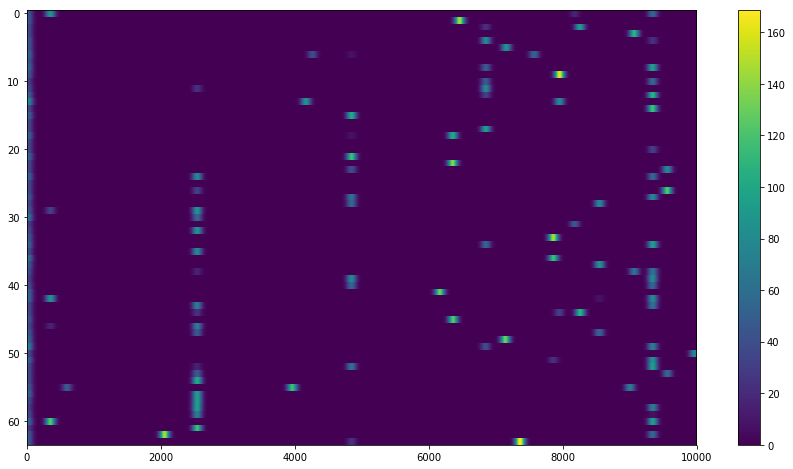

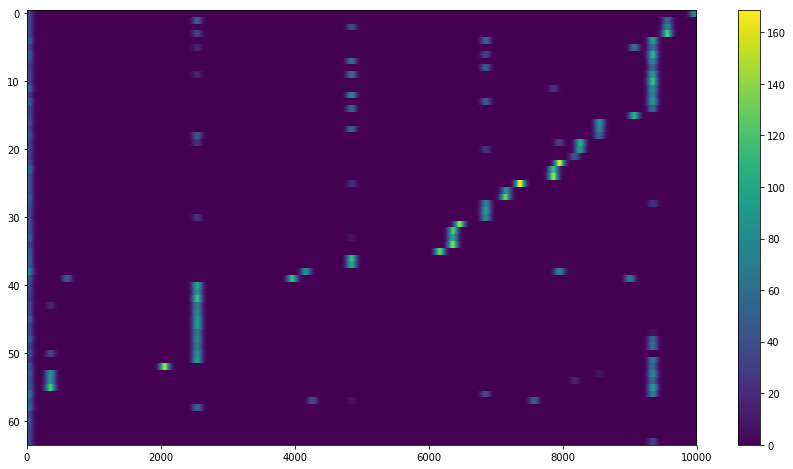

In [21]:
# plt.figure()
test_output = sim.data

enc_spikes = test_output[trained_autoenc_model_probes['enc_spikes']]
enc_rates = rates_kernel(sim.trange(), enc_spikes, tau=0.1)
print(f'Mean encoder output rate is {np.mean(enc_rates)}')

plt.figure(figsize=(15,8));

plot_spikes(sim.trange(), enc_spikes, origin='upper');


plt.figure(figsize=(15,8))
plt.imshow(enc_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();

plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(enc_rates.T, axis=1))
plt.imshow(enc_rates[:,sorted_idxs].T, interpolation="nearest", aspect="auto")
plt.colorbar();



(9999, 64)
Mean value output rate is 7.344165549732997


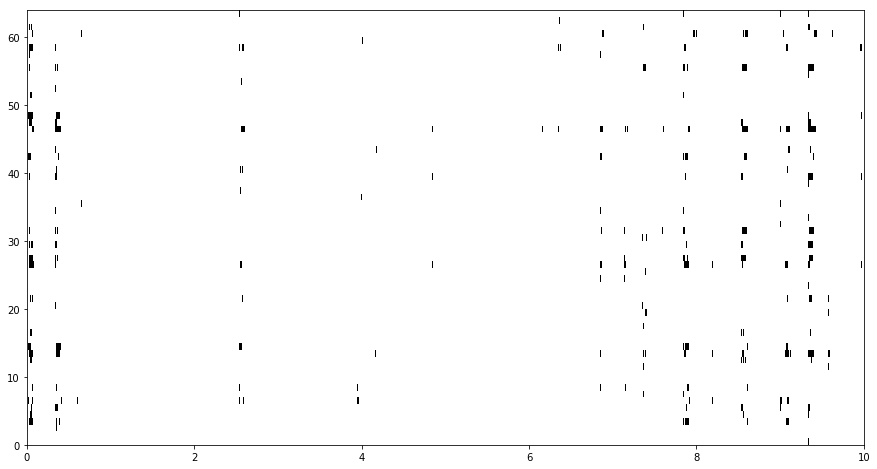

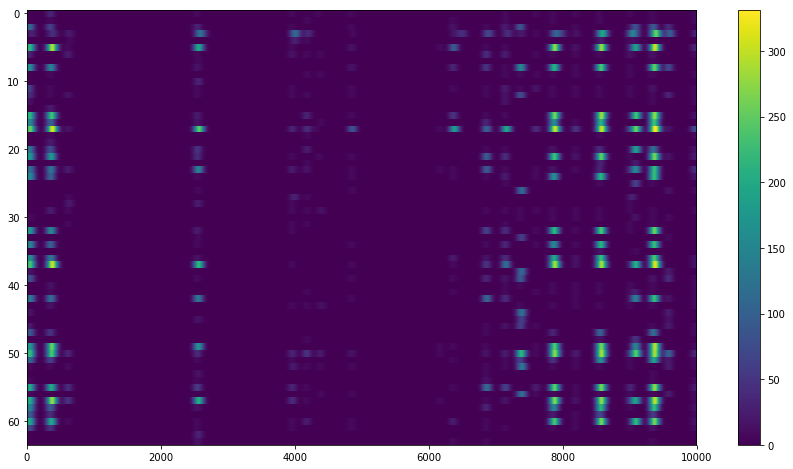

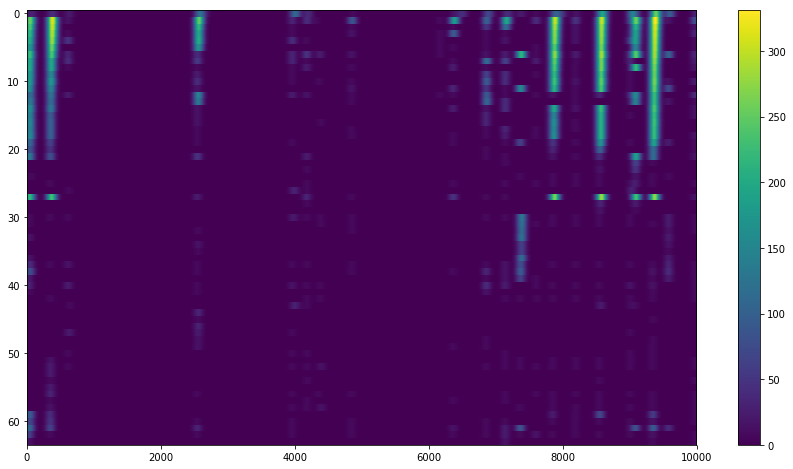

In [22]:
test_output = sim.data
print(test_output[trained_autoenc_model_probes['val_spikes']].shape)

val_spikes = test_output[trained_autoenc_model_probes['val_spikes']]
val_rates = rates_kernel(sim.trange(), val_spikes, tau=0.1)
print(f'Mean value output rate is {np.mean(val_rates)}')

plt.figure(figsize=(15,8));
plot_spikes(sim.trange(), val_spikes);


plt.figure(figsize=(15,8))
plt.imshow(val_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();

plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(val_rates.T, axis=1))
plt.imshow(val_rates[:,sorted_idxs].T, interpolation="nearest", aspect="auto")
plt.colorbar();



(1, 192, 64)


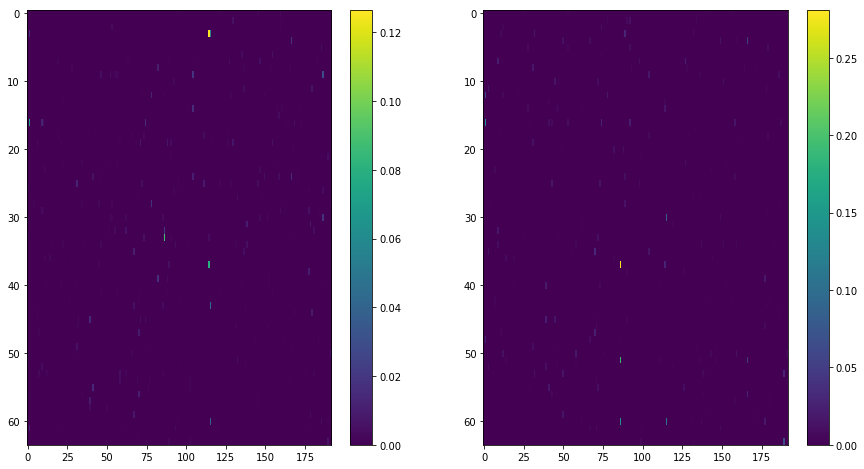

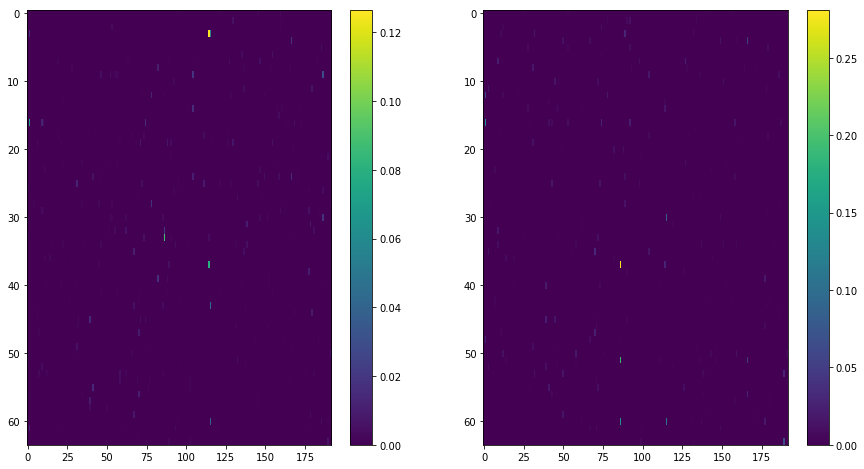

In [24]:
weights_PV_E_0 = test_output[trained_autoenc_model_probes['weights_PV_E_0']]
weights_PV_E_1 = test_output[trained_autoenc_model_probes['weights_PV_E_1']]
print(weights_PV_E_0.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
im1 = ax1.imshow(weights_PV_E_0[0,:,:].T, aspect='auto')
plt.colorbar(im1, ax=ax1);

im2 = ax2.imshow(weights_PV_E_1[0,:,:].T, aspect='auto');
plt.colorbar(im2, ax=ax2);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
im1 = ax1.imshow(weights_PV_E_0[-1,:,:].T, aspect='auto')
plt.colorbar(im1, ax=ax1);

im2 = ax2.imshow(weights_PV_E_1[-1,:,:].T, aspect='auto');
plt.colorbar(im2, ax=ax2);


In [28]:
sorted_test_labels = np.sort(test_labels.flat, kind='stable')
print(np.unique(sorted_test_labels, return_counts=True))
sorted_test_label_idxs = np.argsort(test_labels.flat, kind='stable')



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 98000, 113500, 103200, 101000,  98200,  89200,  95800, 102800,
        97400, 100900]))


In [29]:
target_interval = range(*test_label_ranges[0])

sample = input_labels[:n_test][target_interval]  
sample_ends = sample[range(n_steps-1, sample.shape[0], n_steps)]

for p in sample_ends:
    plt.figure()
    plt.imshow(output[p_c_filt].reshape((-1, 784))[p].reshape((28,28)))
    plt.colorbar()

    

NameError: name 'test_label_ranges' is not defined

(15000, 128)


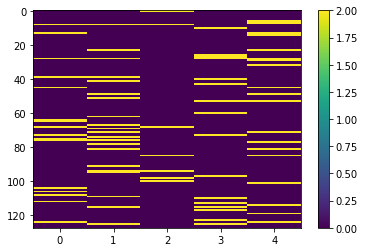

In [145]:
print(input_matrix.shape)
plt.figure()
plt.imshow(input_matrix[sample_ends,:].T, aspect='auto')
plt.colorbar();


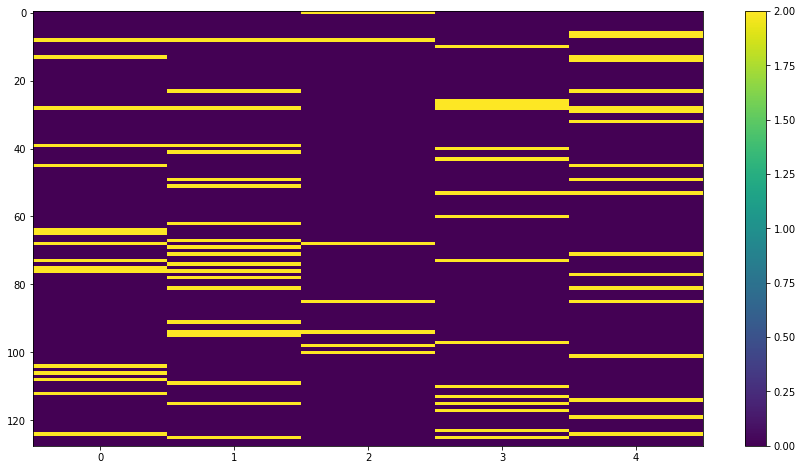

In [146]:
target_interval = range(*test_label_ranges[0])

sample = input_labels[:n_test][target_interval]  
sample_ends = sample[range(n_steps-1, sample.shape[0], n_steps)]

plt.figure(figsize=(15,8))
plt.imshow(input_matrix[sample_ends,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();


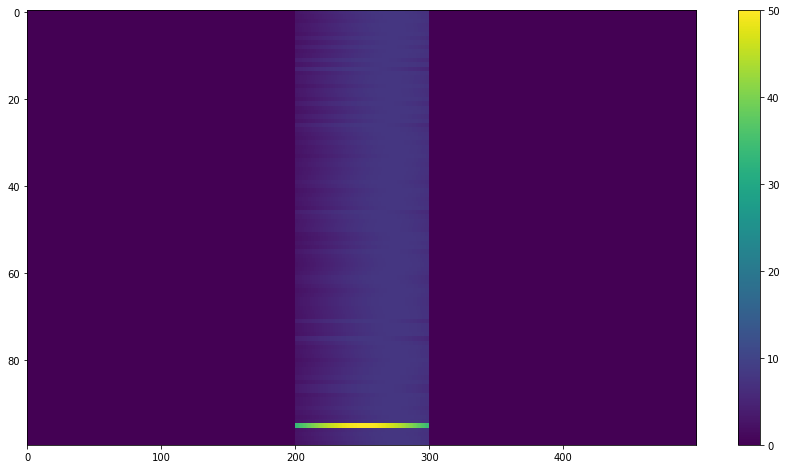

In [159]:
plt.figure(figsize=(15,8))
plt.imshow(output_rates[sample,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();


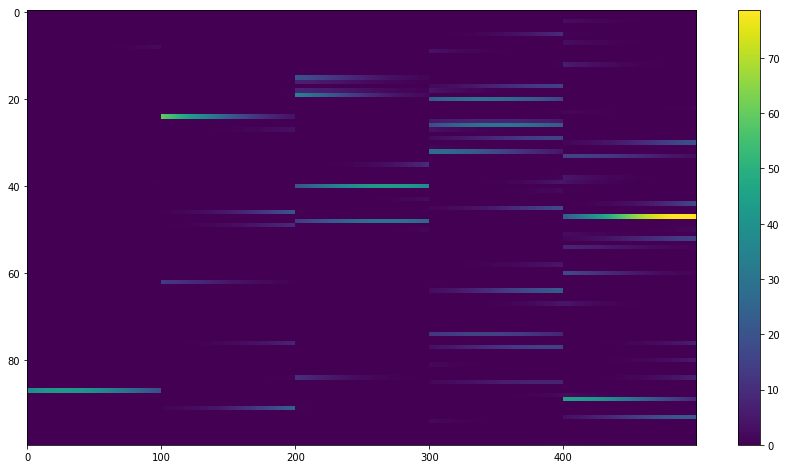

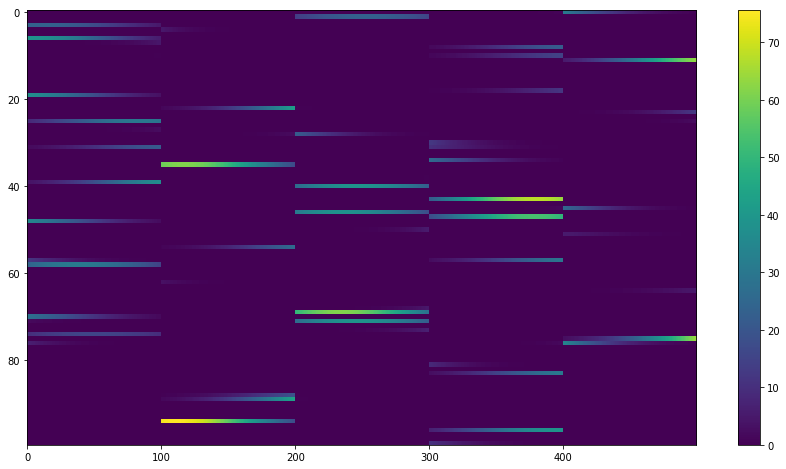

In [162]:

plt.figure(figsize=(15,8))
plt.imshow(output_rates[sample+5000,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();
plt.figure(figsize=(15,8))
plt.imshow(output_rates[sample+10000,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();

